### Import Libraries

In [81]:
import pandas as pd
import numpy as np
import tqdm.notebook as tq
import matplotlib.pyplot as plt
import seaborn as sn
from pathlib import Path

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

### Importing and Processing Data

In [2]:
data_dir = Path().cwd() / "data"

train_df = pd.read_csv( data_dir / "train.csv")
test_df = pd.read_csv( data_dir / "test.csv")

In [3]:
print("Train Size", train_df.shape)
print("Test Size", test_df.shape)

Train Size (200000, 3)
Test Size (50000, 3)


### BERT Fine-Tune last hidden layer

In [4]:
# Parameters
BATCH_SIZE = 128*2
MAX_LEN = 256
EPOCHS = 2
LEARNING_RATE = 1e-3

In [5]:
# Load pre-trained model
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
# PRE_TRAINED_MODEL_NAME = 'bert-large-uncased'
# PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Freeze all parameters in the base BERT model
for param in bert_model.parameters():
    param.requires_grad = False

#### Modify Dataset to adapt to BERT

In [6]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [7]:
# Create Dataset
train_ds = TextDataset(train_df["title"].to_numpy(), train_df["label"].to_numpy(), tokenizer, MAX_LEN)
test_ds = TextDataset(test_df["title"].to_numpy(), test_df["label"].to_numpy(), tokenizer, MAX_LEN)

In [8]:
# Create Data Loaders with the modified datasets
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

#### Fine-Tuned Model

In [21]:
class BertClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        # Adding a new linear layer for classification
        # bert_model.config.hidden_size gives the number of hidden units in the BERT model
            
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes))

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Extract the last hidden state of the token `[CLS]`
        pred = self.classifier(cls_output)
        return pred

In [22]:
# Move model to GPU if available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Used device is:", torch.cuda.get_device_name(device) )

# initiate model
num_classes = np.unique(train_df.label).shape[0]
model = BertClassifier(bert_model, num_classes=num_classes)
model = model.to(device)

Used device is: NVIDIA GeForce RTX 4070 Laptop GPU


In [23]:
# optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# loss function
criterion = nn.CrossEntropyLoss()

In [24]:
train_losses = []
test_accuracy = []

for epoch in tq.tnrange(EPOCHS):
    model.train()
    for batch in tq.tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        correct_predictions = 0
        for batch in tq.tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)
            correct_predictions += (preds == labels).sum().item()

        test_accuracy.append( correct_predictions / len(test_ds) )

        print(f'Test Accuracy after epoch {epoch + 1}: {test_accuracy[-1]:.4f}')
        print("=="*30)

print(">> Done!")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Test Accuracy after epoch 1: 0.7853


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Test Accuracy after epoch 2: 0.7889
>> Done!


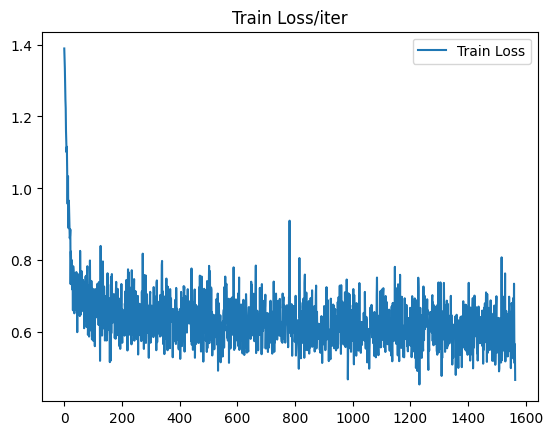

In [25]:
plt.plot(train_losses, label="Train Loss")
plt.title("Train Loss/iter")
plt.legend()
plt.show()

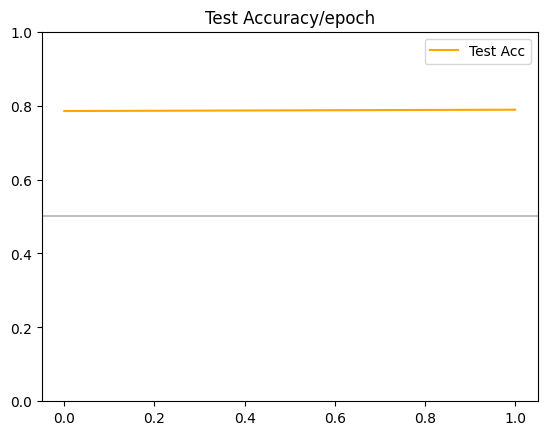

In [26]:
plt.plot(test_accuracy, c="orange", label="Test Acc")
plt.title("Test Accuracy/epoch")
plt.yticks(np.arange(0, 1.1, 0.2))
plt.axhline(0.5, c="gray", alpha=0.5)
plt.legend()
plt.show()

In [39]:
y_pred = []

model.eval()
with torch.no_grad():
    for batch in tq.tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)
        y_pred.append(preds.tolist())

y_pred = np.concatenate(y_pred)

  0%|          | 0/196 [00:00<?, ?it/s]

In [45]:
y_test = test_ds.labels

In [123]:
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_micro": f1_score(y_test, y_pred, average="micro"),
    "f1_macro": f1_score(y_test, y_pred, average="macro"),
    "precision": precision_score(y_test, y_pred, average="macro"),
    "recall": recall_score(y_test, y_pred, average="macro")
}

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize='pred'))

labels = {}
for i,l in test_df[["label", "category"]].drop_duplicates().values:
    labels[i] = l


cm.columns = [labels[i] for i in cm.columns]
cm.index = [labels[i] for i in cm.index]

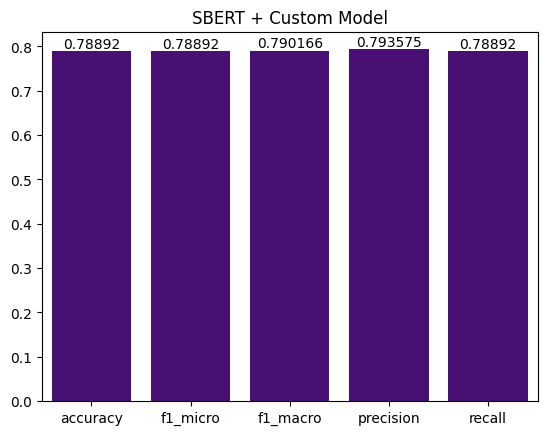

In [129]:
ax = sn.barplot(metrics, color="indigo")
ax.bar_label(ax.containers[0], fontsize=10)
plt.title(f"SBERT + Custom Model")
plt.show()

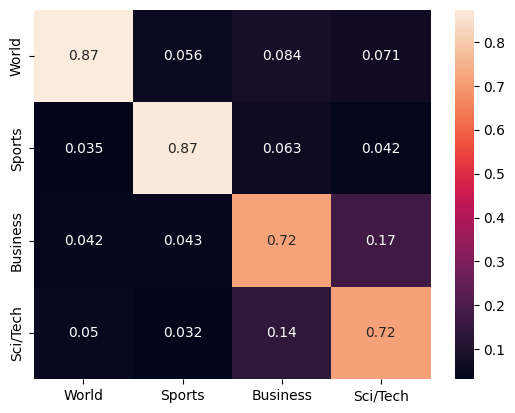

In [127]:
hm = sn.heatmap(cm, annot=True)
plt.show()